In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import scipy.integrate as sci
import time 
import threading
import sys
import multiprocessing as multiproc
import datetime
# the function library
from projectlib import *
import projectlib
from scipy.optimize import fmin as simplex
import random as rd
from joblib import Parallel, delayed

## Parameters

In [2]:
class Data:
    def __init__(self, alpha, beta, dimension, name, commuters_day, N):
        "Dimension gives the dimension of the system, i.e. number of cells"
        # ------- TO DO ---------
        # Depending on the system this has to be adjusted
        self.dimension = dimension
        
        "Alpha describes the rate of infection"
        self.alpha = alpha # Dimensions day^(-1)

        "Beta describes the recovery rate"
        self.beta = beta # Dimensions day^(-1)

        "p is the probability to die from the disease"
        self.p = 2.64e-2
        
        """
        Commuters is an array describing the commuters from and to the different cells. 
        The structure is: The entries in column i are how many commute from i to the cell of the row.
                          Thus, the entries of the row i describe how many commute from different cells to cell i.
        """

        self.commuters = np.array([np.ones(self.dimension) for i in range(self.dimension)])
        "load the txt with given name"
        file = np.loadtxt(name, delimiter="\t")
        "fill commuters with the entries from the file. Note the break statement so it doesn't go to far"
        i = 0
        for row in file:
            if i >= self.dimension:
                break
            self.commuters[i] = np.asarray(row[0:self.dimension])
            i += 1
        
        "Part of day that commuters are in other cells. This is the same value for all cells"
        self.commuters_day = commuters_day

        "Array of population in every cell"
        # ------- TO DO ---------
        # figure out how to best do this
        self.N = N

        
        
    def commutersFrom(self, cfrom):
        """Function to extract the commuters from a cell

        Args:
            cfrom (integer): the cell 

         Returns:
            array: array containing commuters from cfrom
        """
        # ------- TO DO ---------
        # optimize the algorithm
        "Sorting out the necessary entries into array a."
        a = np.zeros(self.dimension)
        for i in range(self.dimension):
            a[i] = self.commuters[i][cfrom]
            
        return a 
    
    def commutersTo(self, cto):
        """Function to return an array with number of commuters coming to cto from other cells.

        Args:
            cto (integer): the cell to which the commuters travel

        Returns:
            array: array containing the commuters to cto.
        """
        return self.commuters[cto][:]
       
        
        

## Functions

In [3]:
def function_of_system(timestep, functions,  data, method, t0):
    """Function to calculate the time derivatives of the dynamic SIRD modell with commuters. This function uses multiple approachs for different variant of the system based on prior assumptions. 

        Args:
            functions (array): array with the functions that define the system of equations. Structure [S_1, ... , S_n, I_1, .... , I_n, R_1, ... , R_n, D_1, ... , D_n]
            timestep (float): time of timestep. t=1 is 1 day
            data (class): the class with the relevant data
            method (string): dictates what method is to be used. The choices are "constant", "heaviside"
            t0 (array): array with len = 3 filled with times at which the heaviside functions in the "heaviside" method switch. 
                Note: all values of t0 have to be between 0 and 1.

        Returns:
            array: array containing the derivatives of functions at time t.
    """
    # array with infected
    Infected = functions[data.dimension:2*data.dimension]

    # initializing the return array with the time derivatives of functions
    dfuncdt = np.zeros(data.dimension*4)

    "~~~~~~~~~~~~~~~~~ See the PDF / LaTeX for further explanation of the equations ~~~~~~~~~~~~~~~~~~~~~~~~"

    # ------------------------------------
    # -     Without commuting effects    -
    # ------------------------------------
    
    if method == 'simple':

        "Please use the function simple_system for the method 'simple'"
    
        # dS/dt
        dfuncdt[0:data.dimension] =  - data.alpha * functions[:data.dimension] * Infected

        # dI/dt \propto -dSdt
        dfuncdt[data.dimension:2*data.dimension] = - dfuncdt[0:data.dimension] - data.beta * Infected

        # dR/dt
        dfuncdt[2*data.dimension:3*data.dimension] = (1 - data.p) * data.beta * Infected

        # dD/dt
        dfuncdt[3*data.dimension:] = data.p * data.beta * Infected
            
        
    
    
    # making array with the effective infected Ieff
    Ieff = np.array([effective_infected(data.commutersTo, data.commutersFrom, data.N, i, Infected, data.dimension) for i in range(data.dimension)])
        
    # ------------------------------------
    # -      Constant Coefficients       -
    # ------------------------------------

    if method == "constant":

        t_out = data.commuters_day #time in another vertex
            
        # the for loop to fill dfuncdt

        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] =  - (1 - t_out) * data.alpha *  functions[i] * functions[i + data.dimension] - t_out * data.alpha * functions[i] * Ieff[i]

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]


    # ------------------------------------
    # -      Heaviside Coefficients      -
    # ------------------------------------

    elif method == "heaviside":


        # the for loop to fill dfuncdt
        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] = - data.alpha * (periodic_heaviside(timestep, t0[0]) + periodic_heaviside(timestep, t0[2]) - 1) * functions[i] * functions[i + data.dimension] - (periodic_heaviside(timestep, t0[1]) - periodic_heaviside(timestep, t0[2])) * data.alpha * functions[i] * Ieff[i]

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]

    
    
    
    
    # returning the derivatives at time t
    return dfuncdt



# Function for using scipy.integrate.odeint, as the arguments are switched
def system_function(functions, timestep, data, method, t0):
    return function_of_system(timestep, functions, data, method, t0)


In [4]:
def simple_system(timestep, functions, data):
    """Function to calculate the time derivatives of the dynamic SIRD modell without commuters. The system may be one specific district (LK), several districts combined or the whole area, this is up to the user (input).

        Args:
            timestep (float): time of timestep. t=1 is 1 day
            functions (array or list): array with the scalar functions (compartments) of the system. Structure [S, I, R, D]
            data (class): the class with the relevant data.

        Returns:
            list: list containing the derivatives of functions at time t.
    """
    S,I,R,D = functions
    dfuncdt = [0,0,0,0]

    # dS/dt
    dfuncdt[0] =  - data.alpha * S * I

    # dI/dt \propto -dSdt
    dfuncdt[1] = - dfuncdt[0] - data.beta * I

    # dR/dt
    dfuncdt[2] = (1 - data.p) * data.beta * I

    # dD/dt
    dfuncdt[3] = data.p * data.beta * I

    return dfuncdt    

In [11]:
#p = 0.0264
#commuters_day = 0.4

 
dimension = 12
### nur 12 LKs 
a = initial_compartment_distribution(12, "2020/07/24")
initCond = np.zeros(12*4)
for i in range(12):
        initCond[i] = a[i][0]
        initCond[i + 12] = a[i][1]
        initCond[i + 24] = a[i][2]
        initCond[i + 36] = a[i][3]
    
M = region_setup(12)[0]
tzero = np.array([0, 0.4, 0.8])

t = np.linspace(0, 100, 10000)
N = import_rki_data(M, 7)[2]
## 38 LKs
b = initial_compartment_distribution(38, "2020/07/24")
initCond38 = np.zeros(38*4)
for i in range(38):
        initCond38[i] = b[i][0]
        initCond38[i + 38] = b[i][1]
        initCond38[i + 38*2] = b[i][2]
        initCond38[i + 38*3] = b[i][3]


commuters = np.array([np.ones(dimension) for i in range(dimension)])
"load the txt with given name"
file = np.loadtxt("Pendler.txt", delimiter="\t")
"fill commuters with the entries from the file. Note the break statement so it doesn't go to far"
i = 0
for row in file:
    if i >= dimension:
            break
    commuters[i] = np.asarray(row[0:dimension])
    i += 1

## Bausteine für Optimierungsverfahren

#### RKI Vergleichsdaten

In [12]:
###find first day of simulation and import RKI_Inzidenzwert
RKI= np.load("Internal Data/rki_region_cases38.npy") 
begin_of_recording = datetime.datetime.strptime("2020/03/01","%Y/%m/%d")
begin_of_simulation = datetime.datetime.strptime("2020/07/24", "%Y/%m/%d")
d0=(begin_of_simulation-begin_of_recording).days
# Inzidenzwert im k-ten Landkreis am d-ten Tag ist RKI[k][2][d0-1+d] 

M_ =  region_setup(38)[0]
N_ = import_rki_data(M_, 7)[2]
#N_ enthält Anzahl der Bevölkerung der Landkreis
RKI_data = np.load("Internal Data/timeline.npy")
I_RKI = np.array([RKI_data[i][1] for i in range(38)])
#I_RKI[Landkreis][Tag]


#### Simulationsdaten

In [13]:
def initial_Condtions(number_of_Lks):
    global initCond
    global initCond38
    global N
    global N_
    if number_of_Lks == 12:
        return initCond, N
    if number_of_Lks == 38:
        return initCond38, N_
    else:
        print("invalid number of regions")
    return


def find_sol_on_days_(solt, soly, lk_indzies, number_of_days, number_of_Lks, results_type = 0):
    # returns X[Landkreis][Tag]  S for results_type = 0, I for results_type = 1, R for results_type=2
    # and D for results_type=3
    start_punkt = results_type * number_of_Lks
    if not lk_indzies: 
        # if list is empty, simulation is calculated for all regions 
        S=np.empty((number_of_Lks,number_of_days+1), dtype=float, order='C')
        for l in range(number_of_Lks):
            k = l + start_punkt
            i=0
            goodtime=0
            for time in range(len(solt)):
                if abs(solt[time]-i)<1e-2:
                    goodtime=time
                    if time+1 <len(solt):
                        if abs(solt[time+1]-i)<abs(solt[time]-i):
                            goodtime=time+1
                    S[l][i]=soly[k][goodtime]
                    i=i+1
    else: # simulation is calculaten for specified regions
        number_of_Lks = len(lk_indzies)
        S = np.empty((number_of_Lks,number_of_days+1), dtype=float, order='C')
        for l in range(number_of_Lks):
            k = lk_indzies[l]
            k = k +start_punkt
            i=0
            goodtime=0
            for time in range(len(solt)):
                if abs(solt[time]-i)<1e-2:
                    goodtime=time
                    if time+1 <len(solt):
                        if abs(solt[time+1]-i)<abs(solt[time]-i):
                            goodtime=time+1
                    S[l][i]=soly[k][goodtime]
                    i=i+1
    return S ## returns X[Landkreis][Tag]


def summon_results(params, method, lk_indzies = [], number_of_days=100,\
                   number_of_Lks=12, results_type = 0):
    # returns S[Landkreis][Tag] for results_type = 0, I for results_type = 1, R for results_type=2
    # and D for results_type=3
    # lk_indzies can be out of order or empty for all regions. 
    dimension = number_of_Lks
    alpha = params[0]
    beta = params[1]
    initConds, X = initial_Condtions(number_of_Lks)
    simulation001 = Data(alpha, beta, dimension, "Pendler.txt", 0.6, X)
    #t = np.linspace(0, number_of_days, t_depth)
    sol = sci.solve_ivp(fun=function_of_system, t_span=(0, number_of_days),\
              y0=initConds, method="RK45", args=(simulation001, method, tzero), t_eval=t, dense_output=True)
    #simulation001 = Data(alpha, beta, dimension, "Pendler.txt", 0.6, import_rki_data(M, 7)[2])
    solt = sol.t
    soly = sol.y
    ss = find_sol_on_days_(solt, soly, lk_indzies, number_of_days, number_of_Lks, results_type)
    return ss


# Usage examples
#print(summon_results([.4,1/14], 'constant',[11,3])) 
#print(len(summon_results([.4,1/14], 'constant')))

#### Tests zur Simulation

Warum ist R größer als I im gleichen Landkreis?

In [14]:
parameter_ = [0.26009148, 0.10547273]
method = 'constant'
Simu_S = summon_results(parameter_, method, number_of_days=100, number_of_Lks=12, results_type =0)
Simu_I = summon_results(parameter_, method, number_of_days=100, number_of_Lks=12, results_type = 1)
Simu_R = summon_results(parameter_, method, number_of_days=100, number_of_Lks=12, results_type = 2)
Simu_D = summon_results(parameter_, method, number_of_days=100, number_of_Lks=12, results_type = 3)


(12, 101)


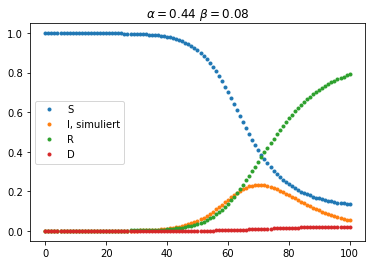

In [15]:
t = np.array([i for i in range(len(Simu_S[1]))])
plt.plot(t,Simu_S[1], '.', label="S")
plt.plot(t,Simu_I[1], '.', label="I, simuliert")
plt.plot(t,Simu_R[1], '.', label="R")
plt.plot(t,Simu_D[1], '.', label="D")
#plt.plot(t,Simu_S[0], '.', label="Lk=1")
#plt.plot(t,Simu_S[2], '.', label="Lk=5")
#plt.plot(t,Simu_S[1], '.', label="Lk=11")
plt.legend()
plt.title("$\\alpha= 0.44$ $ \\beta= 0.08$")
print(Simu_S.shape)

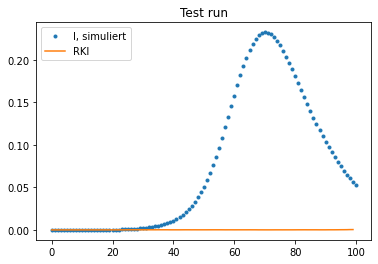

In [16]:
plt.plot(t,Simu_I[1], '.', label="I, simuliert")
plt.plot(t[:100],I_RKI[1], label = 'RKI')
plt.title("Test run")
plt.legend()

#### Berechnung des Inzidenzwerts 

In [17]:
def Inzidenzwert(d,k,is_sim, S):
    # d ist Tag k ist Landkreis
    # die Funktion berechnet Inzidenzwert der Simulation an Tag d in Landkreis k
    if is_sim == 0:
        Oomega = RKI[k][2][d0-1+d]
        return Oomega
    else:
        if d<7:
            Omega = -(S[k][d]-S[k][0])
        if d==0:
            Omega = S[k][0]
        else:
            Omega = -(S[k][d]-S[k][d-7])
            
    return Omega*100000

def find_index(k, lk_indzies = []):
    if not lk_indzies:
        return k
    else:
        return lk_indzies[k]
    
def Omega_ges(N_, d, is_sim, number_of_Lks=12, lk_indzies = [], S = []):
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = 0
    N_tot = 0
    for i in range(numberofLks):
        k = find_index(i, lk_indzies)
        res = res + N_[k]*Inzidenzwert(d,k,is_sim, S)/100000
        N_tot = N_tot + N_[k]
    return res/N_tot
         
Simu = summon_results([0.165,1/14], 'constant',[])
print("Inzidenzwerte im 1-ten Landkreis am Tag 12:")
print("Simulation:", round(Inzidenzwert(12,1,1, Simu),2))
print("RKI:", round(Inzidenzwert(12,1,0, Simu),2))

Inzidenzwerte im 1-ten Landkreis am Tag 12:
Simulation: 2.16
RKI: 1.42


## Bewertungsfunktionen

functions must take the following arguments:

    params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12
    
some version of the following code is required:

    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    x = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks, results_type)
    
    
x ist ein Array der Form x[Landkreis][Tag]    
Wähle results_type = 0 für S, results_type = 1 für I, results_type=2 für R
und results_type=3 für D

In [18]:
def f_0(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    S = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks)
    #S[Landkreis][Tag]
    res = 0
    for d in range(len(S[0])):
        Omega_rki = Omega_ges(N_, d, 0, number_of_Lks, lk_indzies)
        res = res + ((Omega_ges(N_, d, 1, number_of_Lks, lk_indzies, S) - Omega_rki )/Omega_rki)**2
    return res


def f_1(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    S = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks)
    res = 0
    for d in range(len(S[0])):
        Omega_rki = Omega_ges(N_, d, 0, number_of_Lks, lk_indzies)
        res = res + ((Omega_ges(N_, d, 1, number_of_Lks, lk_indzies, S) - Omega_rki )**2/Omega_rki)
    return res


def f_2(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    S = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = 0
    for d in range(len(S[0])):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            res = res + ((Inzidenzwert(d,k,0, S)-Inzidenzwert(d,k,1, S))/(Inzidenzwert(d,k,1, S)))**2
    return res


def f_3(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    S = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = 0
    r = []
    for d in range(len(S[0])):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            
            r.append(((Inzidenzwert(d,k,0, S)-Inzidenzwert(d,k,1, S))/(Inzidenzwert(d,k,1, S)))**2)
    res = sum(r) + 5 * sum([abs(r[k]-sum(r)/len(r)) for k in range(len(r))])
    return res

def f_4(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    S = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = 0
    r = 0
    N_tot = 0
    for d in range(len(S[0])):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            omega_d_k_RKI = Inzidenzwert(d,k,0, S)
            if omega_d_k_RKI == 0:
                r = N_[k]*Inzidenzwert(d,k,1, S)
            else:
                r = N_[k]*((omega_d_k_RKI -Inzidenzwert(d,k,1, S))/(omega_d_k_RKI))**2
            N_tot = N_tot + N_[k]
            res = res + r
    return res/N_tot

def f_5(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    I = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks, results_type = 1)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = 0
    for d in range(number_of_days):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            r = I_RKI[k][d]
            if r == 0:
                i = i+1
            else:
                res = res + ((I[k][d]-r)/r)**2
    return res

def f_6(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    I = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks, results_type = 1)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = []
    N_tot = 0
    for d in range(number_of_days):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            r = I_RKI[k][d] * N_[k]
            if r == 0:
                i = i+1
            else:
                res.append(((N_[k]*I[k][d]-r)/r)**2)
                #N_tot = N_tot + N_[k]
    res = res 
    return sum(res) + 5 * sum([abs(res[k]-sum(res)/len(res)) for k in range(len(res))])

def f_7(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    I = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks, results_type = 1)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = []
    N_tot = 0
    for d in range(number_of_days):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            r = I_RKI[k][d] 
            res.append(abs(N_[k] * (I[i][d] - r)))
            N_tot = N_tot + N_[k] 
    return sum(res)/N_tot #+ 5 * sum([abs(res[k]-sum(res)/len(res)) for k in range(len(res))])

In [12]:
print(f_0([.4,1/14], 'constant'))
print(f_1([.4,1/14], 'constant'))
print(f_2([.4,1/14], 'heaviside'))
print(f_3([.4,1/14], 'heaviside'))
print(f_4([.4,1/14], 'heaviside'))
print(f_5([.4,1/14], 'heaviside'))
print(f_6([.4,1/14], 'heaviside'))
print(f_7([.4,1/14], 'heaviside'))

29741646872.752953
483455.4592821132
344376.444100218
3766368.679072789
347880340.6492751
18721016879.244484


KeyboardInterrupt: 

In [13]:
print(f_7([.3,.4], 'constant'))
print(f_7([.5,.4], 'constant'))
print(f_6([.1,.4], 'constant'))
print(f_7([.7,.4], 'constant'))
print(f_7([.7,.4], 'constant'))

0.0002825683341324002
0.00719162190385313
1541.9391089275587
0.01789045110505478
0.01789045110505478


### In-house optimizer

In [19]:
def Bew(params, function, component_value = 0, which_component =-1,\
        method = 'constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12 ): 
    ## function specifies which Bewertungsfunktion to use
    if which_component == -1:
        return function(params, method, lk_indzies, number_of_days, number_of_Lks)
    else:
        z = params
        z[which_component] = component_value
        return function(z, method, lk_indzies, number_of_days, number_of_Lks)

    
def isbetter(new_eval, current_eval):
    if new_eval > current_eval:
        return 1
    else:
        return 0
    
def improve(params, function, which_component, component_value, sign, evals,\
            method = 'constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    i = 0
    d = 0
    last_sucess = 0
    new_eval = evals
    value = component_value
    o_err=2
    if (which_component == -1):
        while i - last_sucess < 15 and o_err < 4:
            if i - last_sucess >8:
                o_err = o_err + 1
                last_sucess = 0
                i = 0
                component = value
            d = i * 10**(-o_err) * sign * np.array(value)
            component_value = value + d
            evals=new_eval
            new_eval = Bew(params, function, component_value, which_component,\
        method, lk_indzies, number_of_days, number_of_Lks)
            i = i + 1
        if new_eval < evals:
            last_sucess=last_sucess + 1
            value = component_value
            #print(new_eval," ", params)
    i = 0
    d = 0
    last_sucess = 0
    while i - last_sucess < 15 and o_err < 4:
        if i - last_sucess >8:
            o_err = o_err + 1
            last_sucess = 0
            i = 0
            component_value = value
        d = i * 10**(-o_err) * sign
        component_value = value + d
        evals = new_eval
        new_eval = Bew(params, function, component_value, which_component,\
        method, lk_indzies, number_of_days, number_of_Lks )
        i = i + 1
        if new_eval < evals:
            last_sucess=last_sucess + 1
            value = component_value
            #print(new_eval," ", params)
    return value, new_eval
  
   

In [20]:
def improve_component(params, function, which_component, \
            method = 'constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    
    if which_component == -1:
        component_value = params
    else:
        component_value = params[which_component]
    start_eval = Bew(params, function, component_value, which_component)
    component_pos, eval1 = improve(params, function, which_component, component_value, 1, start_eval,\
                                  method, lk_indzies, number_of_days, number_of_Lks)
    component_neg, eval2 = improve(params, function, which_component, component_value, -1, start_eval,\
                                  method, lk_indzies, number_of_days, number_of_Lks)
    if eval1<eval2:
        return component_pos
    else:
        return component_neg


In [21]:
def optimize(parameters, function, \
            method = 'constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    
    improved_paramters=np.array(parameters)
    for e in range(len(parameters)):
        improved_paramters[e] = improve_component(parameters, function, e,\
                                                  method, lk_indzies, number_of_days, number_of_Lks)
    return improve_component(parameters, function, -1,\
                             method, lk_indzies, number_of_days, number_of_Lks)



# Test Optimization

## Simplex

to use copy any of the following cells.   
**args**  can be used as follows:
- **methode** can be either 'constant' or 'heaviside', has default value of 'constant'
- **lk_indzies** is list of specific regions. it can be out of order. leave empty for all regions
- **number_of_Lks** can either be 12 or 36, has default value of 12
- **number_of_days** has default value of 100

In [17]:
simplex(f_6,[0.11103078, 0.10839197], args=('constant',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

#output:
# [0.12000558, 0.10357076]

simplex(f_5,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

#output:
# [0.12000558, 0.10357076]

simplex(f_4,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

#output: 
# [0.4669364 , 0.08100945]

simplex(f_3,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

# output:
# [0.42678053, 0.07426423]

simplex(f_2,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

# output:
# [0.4669364 , 0.08100945]

simplex(f_1,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

# output: 
# [0.36965686, 0.07743744]

simplex(f_0,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

# output: 
# [0.37103014, 0.0782182 ]

Optimization terminated successfully.
         Current function value: 1271.973007
         Iterations: 118
         Function evaluations: 233


KeyboardInterrupt: 

In [ ]:
simplex(f_7,[.4,1/14], args=('constant',[5]), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )


Optimization terminated successfully.
         Current function value: 0.000101
         Iterations: 74
         Function evaluations: 140


array([0.21824659, 0.18449017])

## In-house

**currently is not working correctly!**

to run simply use:

    optimize(parameters, function, method = 'constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12)

Arguments after function are optional:

- **methode** can be either 'constant' or 'heaviside', has default value of 'constant'
- **lk_indzies** is list of specific regions. it can be out of order. leave empty for all regions
- **number_of_Lks** can either be 12 or 36, has default value of 12
- **number_of_days** has default value of 100

In [19]:
functions = [f_7]
function_names = ["f_7"]
res = [optimize([.4,1/14],functions[i], 'constant') for i in range(len(functions))]
for i in range(len(functions)):
    print("used function: ", function_names[i])
    print("Current function value: ", functions[i](res[i], 'constant'))
    print ("optimale Parameter: ", res[i])


used function:  f_7
Current function value:  0.0001752093784536255
optimale Parameter:  [0.039999999999999994, 0.008428571428571426]


In [ ]:
"""used function:  f_0
Current function value:  4503255600.417591
optimale Parameter:  [0.00399999999999999, 0.07142857142857142]
used function:  f_1
Current function value:  66966.04272081747
optimale Parameter:  [0.00399999999999999, 0.05142857142857142]
used function:  f_2
Current function value:  13321447.57504609
optimale Parameter:  [0.01999999999999999, 0.0014285714285714258]
used function:  f_3
Current function value:  128943603.67139372
optimale Parameter:  [0.01999999999999999, 0.0014285714285714258]
used function:  f_4
Current function value:  45837836.13322977
optimale Parameter:  [0.00399999999999999, 0.07142857142857142]"""

'used function:  f_0\nCurrent function value:  4503255600.417591\noptimale Parameter:  [0.00399999999999999, 0.07142857142857142]\nused function:  f_1\nCurrent function value:  66966.04272081747\noptimale Parameter:  [0.00399999999999999, 0.05142857142857142]\nused function:  f_2\nCurrent function value:  13321447.57504609\noptimale Parameter:  [0.01999999999999999, 0.0014285714285714258]\nused function:  f_3\nCurrent function value:  128943603.67139372\noptimale Parameter:  [0.01999999999999999, 0.0014285714285714258]\nused function:  f_4\nCurrent function value:  45837836.13322977\noptimale Parameter:  [0.00399999999999999, 0.07142857142857142]'

## Plots

In [20]:
functions = [f_7]
resolution = 30

alpha = np.linspace(0,1,resolution)
beta = np.linspace(0,1,resolution)
Z_const = np.array([np.zeros((resolution, resolution)) for f in range(len(functions))])
Z_heavi = np.array([np.zeros((resolution, resolution)) for f in range(len(functions))])

for f in range(len(functions)):
    for i in range(len(alpha)):
        for j in range(len(beta)):
            Z_const[f][i][j] = functions[f]([alpha[i],beta[j]], method='constant')
            Z_heavi[f][i][j] = functions[f]([alpha[i],beta[j]], method='heaviside')
        

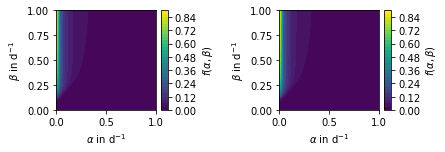

In [22]:
#### Funktion f_7
#ändere die 4 in Z_const[4] um andere Funktionen zu plotten

Zdiff_const = Z_const[0] #- np.mean(Z_const[0])
Zdiff_heavi = Z_const[0] #- np.mean(Z_const[0])

# norm = cm.colors.Normalize(vmax=max(Zdiff_const.max(), Zdiff_heavi.max()), vmin=min(Zdiff_const.min(), Zdiff_heavi.min()))
norm_const = cm.colors.Normalize(vmax=Zdiff_const.max(), vmin=Zdiff_const.min())
norm_heavi = cm.colors.Normalize(vmax=Zdiff_heavi.max(), vmin=Zdiff_heavi.min())
ALPHA, BETA = np.meshgrid(alpha, beta)

# if one colorbar (i.e. corresponding colours) for both plots is wanted:
'''
fig = plt.figure()

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=0.25,
               cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

cset = grid[0].contourf(
    ALPHA, BETA, Zdiff_const, resolution, norm=norm
    )

cset = grid[1].contourf(
    ALPHA, BETA, Zdiff_heavi, resolution, norm=norm
    )

for ax in grid:
    ax.set_xlim(0, 1)

cbar = ax.cax.colorbar(cset)
cbar = grid.cbar_axes[0].colorbar(cset)
'''

fig, (ax1, ax2) = plt.subplots(1,2)
fig.subplots_adjust(wspace=1.0)

cset1 = ax1.contourf(
    ALPHA, BETA, Zdiff_const, resolution, vmax=Zdiff_const.max(), vmin=Zdiff_const.min()
)
ax1.set_xlabel(r'$\alpha$ in $\mathrm{d^{-1}}$')
ax1.set_ylabel(r'$\beta$ in $\mathrm{d^{-1}}$')
ax1.set(adjustable='box', aspect='equal')
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="5%")
cbar1 = fig.colorbar(cset1, cax=cax1)
cbar1.set_label(r'$f(\alpha,\beta)$')

cset2 = ax2.contourf(
    ALPHA, BETA, Zdiff_heavi, resolution, vmax=Zdiff_heavi.max(), vmin=Zdiff_heavi.min()
)
ax2.set_xlabel(r'$\alpha$ in $\mathrm{d^{-1}}$')
ax2.set_ylabel(r'$\beta$ in $\mathrm{d^{-1}}$')
ax2.set(adjustable='box', aspect='equal')
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="7%", pad="5%")
cbar2 = fig.colorbar(cset2, cax=cax2)
cbar2.set_label(r'$f(\alpha,\beta)$')

#plt.savefig("./Media/Plots/opt/f_plot.pdf", dpi=400)
plt.show()

#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_ylim(0, 1)
#ax.set_xticks([])
#ax.set_yticks([])

#Zdiff_const

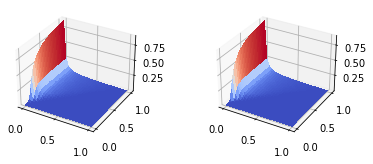

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, subplot_kw={"projection": "3d"})
fig.subplots_adjust(wspace=0.5)
surf1 = ax1.plot_surface(ALPHA, BETA, Zdiff_const, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf2 = ax2.plot_surface(ALPHA, BETA, Zdiff_heavi, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


## Fehler der Parameter

**Vorsicht!**
Die nächste Zelle dauert seher **lange!**

In [24]:
function = f_7 ## welche Bewertungsfunktion verwendet werden soll
sample_size = 10
alpha_ = np.linspace(0,1,sample_size)
beta_ = np.linspace(0,1,sample_size)
optimal_params_const = []
optimal_params_heavi = []
optimal_params_simple = []

for i in range(sample_size):
        for j in range(sample_size):
                optimal_params_const.append(simplex(function,[alpha_[i],beta_[j]],\
                    args=('constant',), xtol=0.0001, ftol=0.0001,\
                    maxiter=None, maxfun=None, full_output=0, disp=1,\
                    retall=0, callback=None, initial_simplex=None ))
                optimal_params_heavi.append(simplex(function,[alpha_[i],beta_[j]],\
                    args=('heaviside',), xtol=0.0001, ftol=0.0001,\
                    maxiter=None, maxfun=None, full_output=0, disp=1,\
                    retall=0, callback=None, initial_simplex=None ))
                optimal_params_simple.append(simplex(function,[alpha_[i],beta_[j]],\
                    args=('simple',), xtol=0.0001, ftol=0.0001,\
                    maxiter=None, maxfun=None, full_output=0, disp=1,\
                    retall=0, callback=None, initial_simplex=None ))
            


Optimization terminated successfully.
         Current function value: 0.000176
         Iterations: 24
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000249
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000161
         Iterations: 91
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 0.000251
         Iterations: 27
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000243
         Iterations: 39
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 0.000248
         Iterations: 26
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 0.000161
         Iterations: 101
         Function evaluations: 192
Optimization terminated success

Use the cell below. It runs with joblib and is using 7 cores (in case of pc with less cores this will have to be adjusted).

To install joblib see <https://anaconda.org/anaconda/joblib>


In [64]:
def f_8(params0, params1 = 1/14, method ='heaviside', lk_indzies = [], number_of_days = 100, number_of_Lks = 38):
    params = [params0, params1]
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    I = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks, results_type = 1)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = []
    for d in range(number_of_days):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            r = I_RKI[k][d] 
            res.append((I[i][d]-r)**2)
    return sum(res) #/N_tot + 5 * sum([abs(res[k]-sum(res)/len(res)) for k in range(len(res))])

def f_8_1(params, method ='heaviside', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    I = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks, results_type = 1)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = []
    for d in range(number_of_days):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            r = I_RKI[k][d] 
            res.append((I[i][d]-r)**2)
    return sum(res) #/N_tot + 5 * sum([abs(res[k]-sum(res)/len(res)) for k in range(len(res))])

### Heavi with 12 LK

In [12]:
from joblib import Parallel, delayed
num_it = 10
alpha = np.linspace(0, 1, num_it)
beta = np.linspace(0, 0.2, num_it)
function = f_7

#opt_const = Parallel(n_jobs=3)(delayed(simplex)(function,[alpha[i], beta[j]], args=('constant',[5]), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))
opt_heavi = Parallel(n_jobs=11)(delayed(simplex)(function,[alpha[i], beta[j]], args=('heaviside',[5]), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))
#opt_simple = Parallel(n_jobs=3)(delayed(simplex)(function,[alpha[i], beta[j]], args=('simple',[5]), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))

In [13]:

print(opt_heavi)


[array([4.0234375e-04, 7.8125000e-06]), array([0.00402344, 0.00128472]), array([0.00314063, 0.00027778]), array([0.00318872, 0.00127604]), array([0.00226376, 0.00136285]), array([1.39062500e-03, 1.76941795e-16]), array([9.59472656e-04, 7.81250000e-05]), array([1.01464844e-03, 6.07638889e-05]), array([0.00128076, 0.00059028]), array([1.32812500e-03, 2.54136989e-16]), array([1.15796448e-01, 5.47342263e-05]), array([0.11133965, 0.02332804]), array([0.11742282, 0.04416748]), array([0.11875   , 0.06291667]), array([0.10844794, 0.09359484]), array([0.1120714 , 0.10849067]), array([0.11684028, 0.13302083]), array([0.11531304, 0.15960395]), array([0.11453807, 0.17474311]), array([0.1140625 , 0.21546875]), array([0.07334866, 0.00238204]), array([0.21871054, 0.02326966]), array([0.22129829, 0.0472719 ]), array([0.15034722, 0.07981771]), array([0.21396213, 0.09996311]), array([0.22231852, 0.116647  ]), array([0.2297031 , 0.13707092]), array([0.24440231, 0.14002065]), array([0.23333333, 0.17777778

In [14]:
from joblib import Parallel, delayed
from numpy import array
# Find params with minimal f_7
params_candidates_heavi = opt_heavi
f_heavi = []

f_heavi = Parallel(n_jobs=7)(delayed(f_7)(p, "heaviside") for p in params_candidates_heavi)


In [15]:
print("Optimale Parameter (heavi):",params_candidates_heavi[np.argmin(f_heavi)])

print(min(f_heavi))


Optimale Parameter (heavi): [0.33565674 0.18297201]
0.00010342412113942512


### Heavi with 38

In [12]:
from joblib import Parallel, delayed
num_it = 10
alpha = np.linspace(0, 1, num_it)
beta = np.linspace(0, 0.2, num_it)
function = f_7

#opt_const = Parallel(n_jobs=3)(delayed(simplex)(function,[alpha[i], beta[j]], args=('constant',[5]), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))
opt_heavi = Parallel(n_jobs=11)(delayed(simplex)(function,[alpha[i], beta[j]], args=('heaviside',[5], 100, 38), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))
#opt_simple = Parallel(n_jobs=3)(delayed(simplex)(function,[alpha[i], beta[j]], args=('simple',[5]), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))

In [13]:
print(opt_heavi)
params_candidates_heavi = opt_heavi
f_heavi = []

f_heavi = Parallel(n_jobs=7)(delayed(f_7)(p, "heaviside") for p in params_candidates_heavi)
print("Optimale Parameter (heavi):",params_candidates_heavi[np.argmin(f_heavi)])

print(min(f_heavi))


[array([3.93554688e-04, 9.76562500e-06]), array([0.00285895, 0.00045573]), array([0.00386069, 0.00011292]), array([0.00312402, 0.0003125 ]), array([0.00300415, 0.00045139]), array([0.00290626, 0.00058525]), array([0.00467773, 0.0009375 ]), array([0.00425195, 0.00012153]), array([0.00415625, 0.00111111]), array([0.00312402, 0.0009375 ]), array([0.10551147, 0.00025032]), array([0.11145833, 0.024375  ]), array([0.11111111, 0.04666667]), array([0.11666667, 0.06666667]), array([0.1140625 , 0.08604167]), array([0.11432292, 0.10733507]), array([0.11216634, 0.13301432]), array([0.1125    , 0.15944444]), array([0.11078033, 0.1790389 ]), array([0.11679789, 0.20507965]), array([0.20747342, 0.00088953]), array([0.10238715, 0.03272678]), array([0.22221382, 0.04666632]), array([0.17569444, 0.07421875]), array([0.21666667, 0.10222222]), array([0.2375, 0.1125]), array([0.22548218, 0.13585531]), array([0.22803819, 0.15588976]), array([0.23333333, 0.18222222]), array([0.2316714 , 0.20502068]), array([3.

### Const with 12 LK

In [14]:
from joblib import Parallel, delayed
num_it = 10
alpha = np.linspace(0, 1, num_it)
beta = np.linspace(0, 0.2, num_it)
function = f_7

opt_const = Parallel(n_jobs=3)(delayed(simplex)(function,[alpha[i], beta[j]], args=('constant',[5]), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))
#opt_heavi = Parallel(n_jobs=11)(delayed(simplex)(function,[alpha[i], beta[j]], args=('heaviside',[5], 100, 38), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))
#opt_simple = Parallel(n_jobs=3)(delayed(simplex)(function,[alpha[i], beta[j]], args=('simple',[5]), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))

print(opt_const)
params_candidates_const = opt_const
f_const = []

f_const = Parallel(n_jobs=7)(delayed(f_7)(p, "constant") for p in params_candidates_const)
print("Optimale Parameter (const):",params_candidates_const[np.argmin(f_const)])

print(min(f_const))

[array([0.03376452, 0.00144614]), array([3.23918754e-02, 8.95604201e-05]), array([0.03255881, 0.00018589]), array([0.03259783, 0.00028821]), array([0.03740897, 0.00502813]), array([0.06152052, 0.02884664]), array([0.03731428, 0.00493265]), array([4.73437500e-03, 5.37764278e-17]), array([0.03270626, 0.00035775]), array([4.73437500e-03, 2.08166817e-16]), array([0.03528185, 0.00292502]), array([0.21834997, 0.18459269]), array([0.21820427, 0.18444759]), array([0.21800242, 0.18424654]), array([0.21839879, 0.1846413 ]), array([0.21827018, 0.18451323]), array([0.21834336, 0.18458609]), array([0.218401 , 0.1846435]), array([0.21835513, 0.18459781]), array([0.21839253, 0.18463506]), array([0.03604198, 0.00368284]), array([0.21836806, 0.1846107 ]), array([0.21845818, 0.18470044]), array([0.21836621, 0.18460886]), array([0.21847767, 0.18471985]), array([0.21851314, 0.18475519]), array([0.2183683 , 0.18461093]), array([0.21867782, 0.18491923]), array([0.21842316, 0.18466557]), array([0.21845881, 0

### Const with 38

In [16]:
opt_const = Parallel(n_jobs=11)(delayed(simplex)(function,[alpha[i], beta[j]], args=('constant',[5], 100, 38), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))
#opt_heavi = Parallel(n_jobs=11)(delayed(simplex)(function,[alpha[i], beta[j]], args=('heaviside',[5], 100, 38), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))
#opt_simple = Parallel(n_jobs=3)(delayed(simplex)(function,[alpha[i], beta[j]], args=('simple',[5]), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None) for i in range(num_it) for j in range(num_it))

print(opt_const)
params_candidates_const = opt_const
f_const = []

f_const = Parallel(n_jobs=7)(delayed(f_7)(p, "constant") for p in params_candidates_const)
print("Optimale Parameter (const):",params_candidates_const[np.argmin(f_const)])

print(min(f_const))

[array([0.03387223, 0.0014956 ]), array([3.23910091e-02, 7.08364716e-05]), array([0.03255881, 0.00018589]), array([0.03255243, 0.00022675]), array([0.03740897, 0.00502813]), array([0.18494472, 0.15207207]), array([0.03739371, 0.00502105]), array([4.73437500e-03, 5.37764278e-17]), array([0.03267542, 0.00036057]), array([4.73437500e-03, 2.08166817e-16]), array([0.03530078, 0.00293242]), array([0.18508317, 0.15221077]), array([0.1850477 , 0.15217525]), array([0.18503163, 0.15215914]), array([0.18499689, 0.15212434]), array([0.18500622, 0.15213371]), array([0.18501549, 0.15214299]), array([0.18506629, 0.15219388]), array([0.18519135, 0.15231915]), array([0.18499489, 0.15212235]), array([0.03594909, 0.00357776]), array([0.18496271, 0.15209009]), array([0.18504767, 0.15217521]), array([0.18489213, 0.1520194 ]), array([0.18506514, 0.15219273]), array([0.18502174, 0.15214923]), array([0.1850269, 0.1521544]), array([0.18517251, 0.15230028]), array([0.18494943, 0.15207678]), array([0.18528301, 0

In [ ]:
alpha_mean_const = sum([optimal_params_const[i][0]\
                        for i in range(len(optimal_params_const))])/len(optimal_params_const)
alpha_mean_heavi = sum([optimal_params_heavi[i][0]\
                        for i in range(len(optimal_params_heavi))])/len(optimal_params_heavi)
alpha_mean_simple = sum([optimal_params_simple[i][0]\
                        for i in range(len(optimal_params_simple))])/len(optimal_params_simple)
alpha_stdev_const = np.std(np.array([optimal_params_heavi[i][1]\
                                       for i in range(len(optimal_params_heavi))]))  
alpha_stdev_heavi = np.std(np.array([optimal_params_heavi[i][1]\
                                       for i in range(len(optimal_params_heavi))])) 
alpha_stdev_simple = np.std(np.array([optimal_params_simple[i][1]\
                                       for i in range(len(optimal_params_simple))]))  


beta_mean_const = sum([optimal_params_const[i][1]\
                        for i in range(len(optimal_params_const))])/len(optimal_params_const)
beta_mean_heavi = sum([optimal_params_heavi[i][1]\
                        for i in range(len(optimal_params_heavi))])/len(optimal_params_heavi)
beta_mean_simple = sum([optimal_params_simple[i][1]\
                        for i in range(len(optimal_params_simple))])/len(optimal_params_simple)
beta_stdev_const = np.std(np.array([optimal_params_const[i][1]\
                                       for i in range(len(optimal_params_heavi))]))   
beta_stdev_heavi = np.std(np.array([optimal_params_heavi[i][1]\
                                       for i in range(len(optimal_params_heavi))])) 
beta_stdev_simple = np.std(np.array([optimal_params_simple[i][1]\
                                       for i in range(len(optimal_params_simple))]))  

In [ ]:
print("Optimierte Bewertungsfunktion f_7")
print("alpha_const = ", alpha_mean_const, "mit Fehler: ", alpha_stdev_const)
print("beta_const = ", beta_mean_const, "mit Fehler: ", beta_stdev_const)
print("alpha_heavi = ", alpha_mean_heavi, "mit Fehler: ", alpha_stdev_heavi)
print("beta_heavi = ", beta_mean_heavi, "mit Fehler: ", beta_stdev_heavi)
print("alpha_simple = ", alpha_mean_simple, "mit Fehler: ", alpha_stdev_simple)
print("beta_simple = ", beta_mean_simple, "mit Fehler: ", beta_stdev_simple)

Optimierte Bewertungsfunktion f_7
alpha_const =  0.5 mit Fehler:  0.4292056846172732
beta_const =  0.5 mit Fehler:  0.408248290463863
alpha_heavi =  0.3510723126729329 mit Fehler:  0.4292056846172732
beta_heavi =  0.34913683954874636 mit Fehler:  0.4292056846172732


[array([0., 0.]),
 array([0. , 0.5]),
 array([0., 1.]),
 array([0.5, 0. ]),
 array([0.5, 0.5]),
 array([0.5, 1. ]),
 array([1., 0.]),
 array([1. , 0.5]),
 array([1., 1.])]

## Parameter der einzelnen Landkreise

In [ ]:
res =simplex(f_7,[0.4,1/14],args=('constant',[37], 100, 38),xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None,\
            full_output=0, disp=0, retall=0, callback=None, initial_simplex=None )
print(res)

[0.4        0.07142857]


In [ ]:
Lk_params_const = []
Lk_params_heavi = []
counter = 0
for region_id in range(38):
    const = simplex(f_7,[0.4,1/14],\
            args=('constant',[region_id], 100, 38),\
            xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None,\
            full_output=0, disp=0, retall=0, callback=None, initial_simplex=None )
    Lk_params_const.append(const)
    counter = counter + 1
    print("Noch ", 38 * 2 -counter, "Schritte fehlen.")
    heavi = simplex(f_7,[0.4,1/14],\
            args=('heaviside',[region_id], 100, 38),\
            xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None,\
            full_output=0, disp=0, retall=0, callback=None, initial_simplex=None )
    Lk_params_heavi.append(heavi)
    counter = counter + 1
    print("Noch ", 38 * 2 -counter, "Schritte fehlen.")
    

Noch  75 Schritte fehlen.
Noch  74 Schritte fehlen.
Noch  73 Schritte fehlen.
Noch  72 Schritte fehlen.
Noch  71 Schritte fehlen.
Noch  70 Schritte fehlen.
Noch  69 Schritte fehlen.
Noch  68 Schritte fehlen.
Noch  67 Schritte fehlen.
Noch  66 Schritte fehlen.
Noch  65 Schritte fehlen.
Noch  64 Schritte fehlen.
Noch  63 Schritte fehlen.
Noch  62 Schritte fehlen.
Noch  61 Schritte fehlen.
Noch  60 Schritte fehlen.
Noch  59 Schritte fehlen.
Noch  58 Schritte fehlen.
Noch  57 Schritte fehlen.
Noch  56 Schritte fehlen.
Noch  55 Schritte fehlen.
Noch  54 Schritte fehlen.
Noch  53 Schritte fehlen.
Noch  52 Schritte fehlen.
Noch  51 Schritte fehlen.
Noch  50 Schritte fehlen.
Noch  49 Schritte fehlen.
Noch  48 Schritte fehlen.
Noch  47 Schritte fehlen.
Noch  46 Schritte fehlen.
Noch  45 Schritte fehlen.
Noch  44 Schritte fehlen.
Noch  43 Schritte fehlen.
Noch  42 Schritte fehlen.
Noch  41 Schritte fehlen.
Noch  40 Schritte fehlen.
Noch  39 Schritte fehlen.
Noch  38 Schritte fehlen.
Noch  37 Sch

In [ ]:
Lk_params_const

[array([0.93346809, 0.86206226]),
 array([2.07908398, 1.99434159]),
 array([0.14631017, 0.10969893]),
 array([0.35332223, 0.30747442]),
 array([0.0452348 , 0.00023113]),
 array([0.1454238 , 0.11067805]),
 array([0.06735215, 0.00021508]),
 array([0.42628618, 0.38509384]),
 array([3.96013229e-02, 2.26832136e-07]),
 array([0.16184209, 0.11946573]),
 array([0.15295574, 0.09638662]),
 array([0.47138627, 0.43733065]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array([0.4       , 0.07142857]),
 array

### To do:
 - **bessere Bewertungsfunktion finden!** (wichtig)
 - **Bewertungsfunktionen plotten** (für die richtige Funktion)
 - **Plots in einer Zelle fügen**
 - **Fehler der Parameter abschätzen** (für die richtige Funktion)
 - **In house optimierer verbessern oder streichen**
 


In [ ]:
function = f_7 ## welche Bewertungsfunktion verwendet werden soll
sample_size = 3
alpha_ = np.linspace(0,1,sample_size)
beta_ = np.linspace(0,1,sample_size)
optimal_params_const = []
optimal_params_heavi = []

for i in range(sample_size):
        for j in range(sample_size):
            optimal_params_const.append(simplex(function,[alpha_[i],beta_[j]],\
                    args=('const',), xtol=0.0001, ftol=0.0001,\
                    maxiter=None, maxfun=None, full_output=0, disp=1,\
                    retall=0, callback=None, initial_simplex=None ))
            optimal_params_heavi.append(simplex(function,[alpha_[i],beta_[j]],\
                    args=('heaviside',), xtol=0.0001, ftol=0.0001,\
                    maxiter=None, maxfun=None, full_output=0, disp=1,\
                    retall=0, callback=None, initial_simplex=None ))
            


Optimization terminated successfully.
         Current function value: 49.499749
         Iterations: 3
         Function evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000249
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 49.499749
         Iterations: 9
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000247
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 49.499749
         Iterations: 10
         Function evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000249
         Iterations: 35
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 49.499749
         Iterations: 9
         Function evaluations: 35
Optimization terminated successfu